In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


***importing libraries***

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

***loading datasets***

In [4]:
train=pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test=pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

***Exploratory Data Analysis***

In [5]:
train.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [6]:
train.shape

(39211, 16)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

***key statistics***

In [8]:
train.describe(include='all')

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
count,39211,39211.000000,38982,39211,37744,39211,39211.000000,39211,39211,28875,39211.000000,39211.000000,39211.000000,39211.000000,9760,39211
unique,1013,NaN,11,3,3,2,NaN,2,2,2,NaN,NaN,NaN,NaN,3,2
top,2009-05-15,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,NaN,NaN,NaN,failure,no
freq,313,NaN,7776,22691,19584,36954,NaN,21657,31820,25030,NaN,NaN,NaN,NaN,4949,33384
mean,NaN,42.120247,NaN,NaN,NaN,NaN,5441.781719,NaN,NaN,NaN,439.062789,5.108770,72.256051,11.826171,NaN,NaN
std,NaN,12.709352,NaN,NaN,NaN,NaN,16365.292065,NaN,NaN,NaN,769.096291,9.890153,160.942593,44.140259,NaN,NaN
min,NaN,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,NaN,33.000000,NaN,NaN,NaN,NaN,98.000000,NaN,NaN,NaN,109.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,NaN,40.000000,NaN,NaN,NaN,NaN,549.000000,NaN,NaN,NaN,197.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,NaN,50.000000,NaN,NaN,NaN,NaN,2030.000000,NaN,NaN,NaN,380.000000,4.000000,-1.000000,0.000000,NaN,NaN


In [9]:
train.isnull().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

***distribution of numerical features***

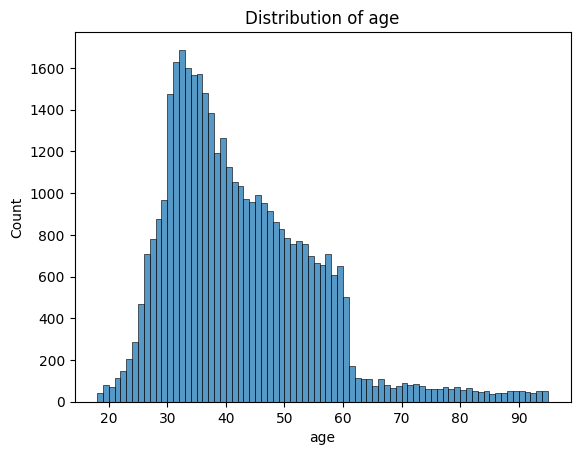

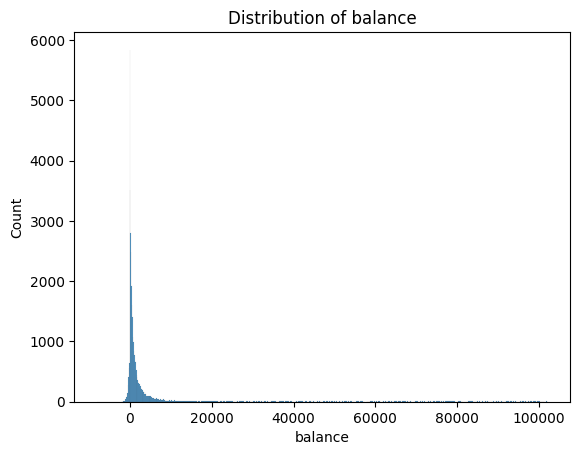

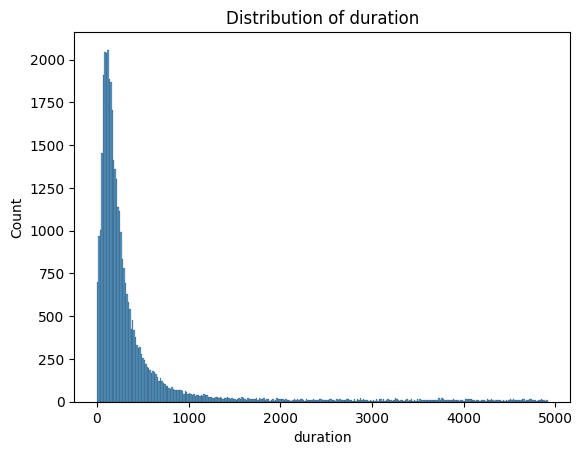

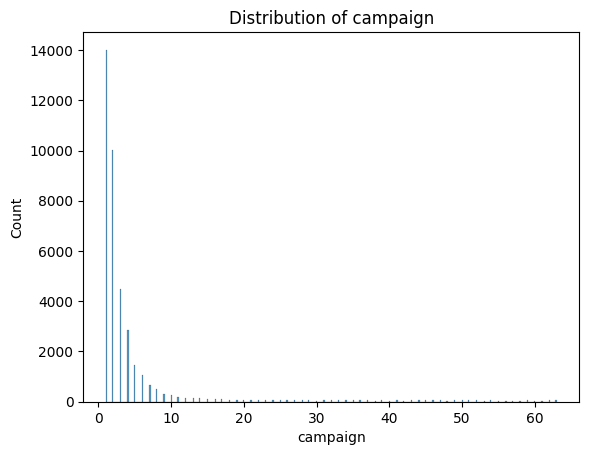

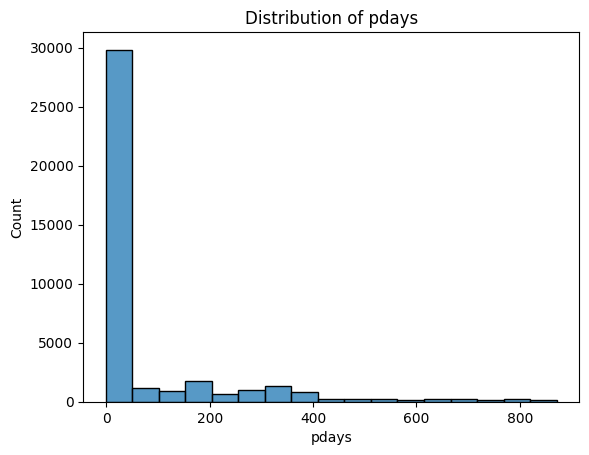

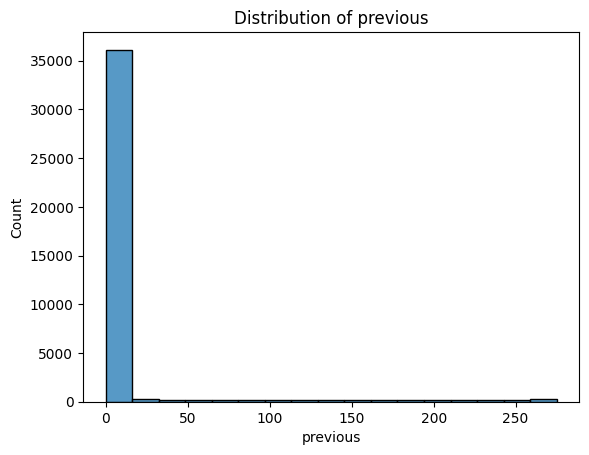

In [10]:
numerical_features = train.select_dtypes(include=['int64']).columns.tolist()
for col in numerical_features:
    sns.histplot(train[col])
    plt.title(f'Distribution of {col}')
    plt.show()

***relationship between variables***

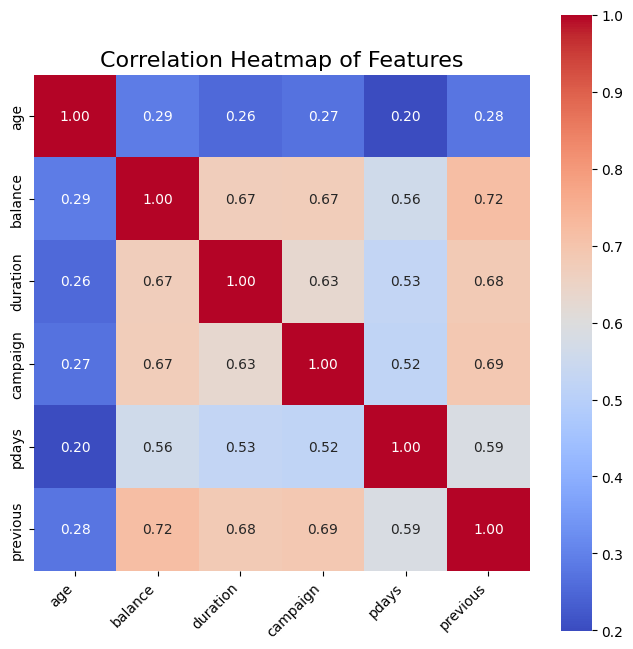

In [11]:
matrix = train[numerical_features].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(
    matrix, 
    cmap='coolwarm', 
    annot=True,  
    fmt='.2f',    
    cbar=True, 
    square=True,  
    xticklabels=matrix.columns, 
    yticklabels=matrix.columns
)
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

***categorical features distribution***

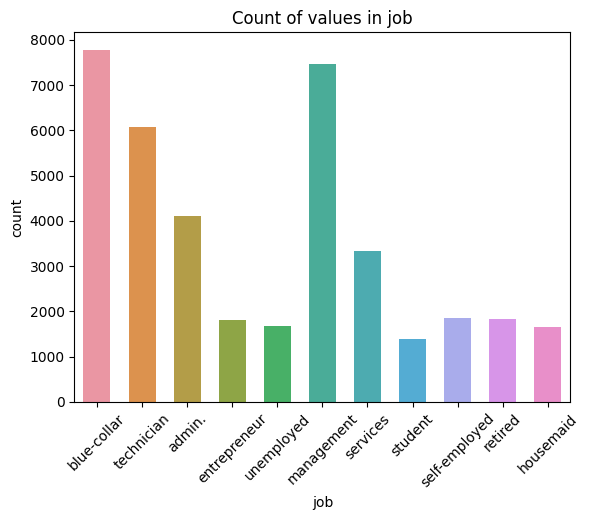

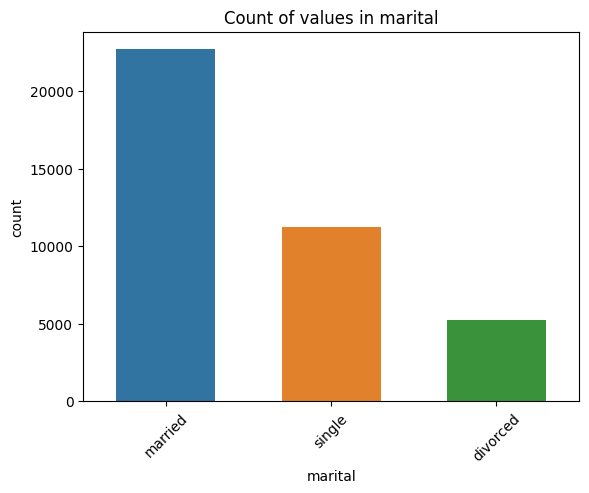

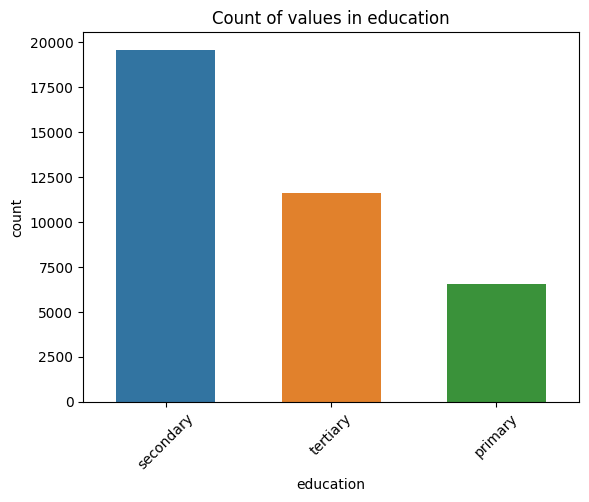

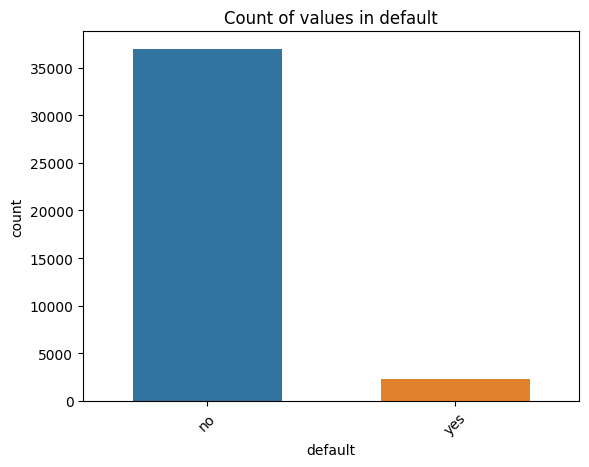

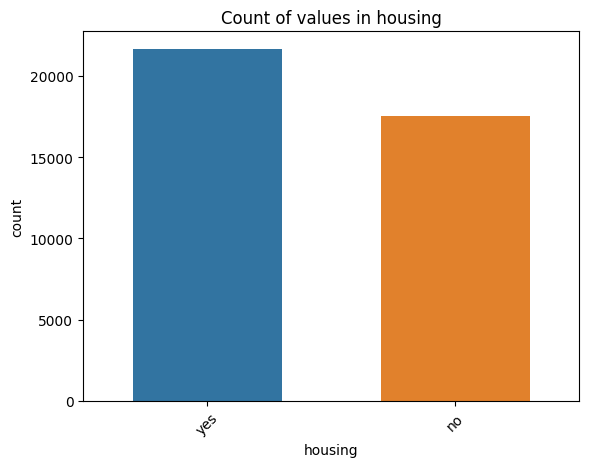

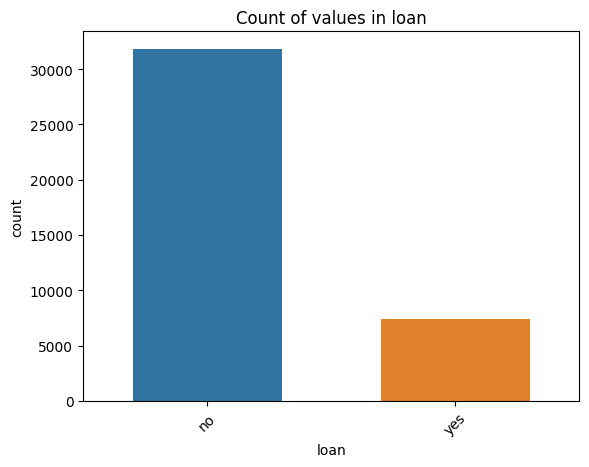

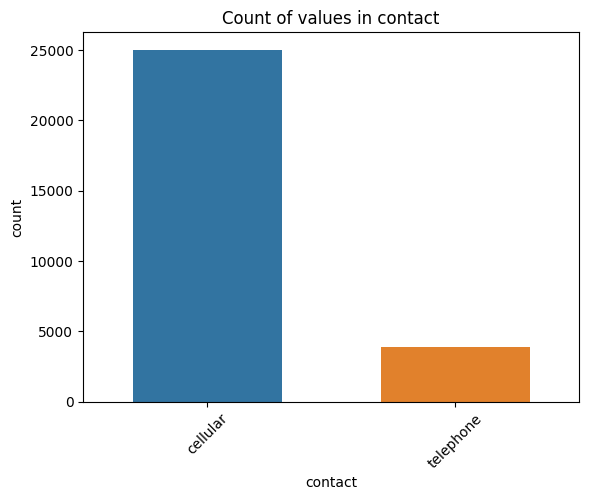

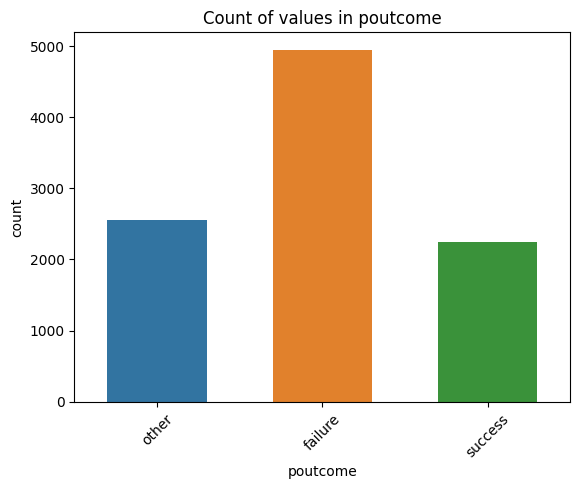

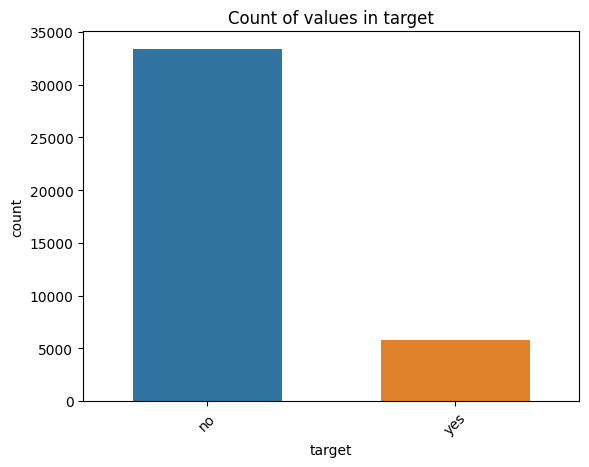

In [12]:
categorical_features = train.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('last contact date')
for col in categorical_features:
    sns.countplot(x=col, data=train, width=0.6)
    plt.title(f'Count of values in {col}')
    plt.xticks(rotation=45)
    plt.show()

***Important findings from data***
* there were no missing values in numerical features.
* all missing values were from categorical features naming 'job','contact','education'and 'poutcome'.
* there were negative values present in 2 features naming 'balance' and 'pdays'.
* maximum number of people are from blue collar jobs while the minimum number are students.
* the dataset only include adult people above the age of 18 and the mean age is 42 years.
* the maximum number of population is married and have secondary education.

***handling missing values***

In [13]:
train=train.fillna('unknown')
test=test.fillna('unknown')

***feature engineering for date***

In [14]:
train['last contact date'] = pd.to_datetime(train['last contact date'])
test['last contact date'] = pd.to_datetime(test['last contact date'])
current_date = datetime.now()
train['lastcontactdays'] = (current_date - train['last contact date']).dt.days
test['lastcontactdays'] = (current_date - test['last contact date']).dt.days
train.drop(columns=['last contact date'], inplace=True)
test.drop(columns=['last contact date'], inplace=True)

***transforming categorical features to numerical***

In [15]:
train[['default', 'housing', 'loan','target']] = train[['default', 'housing', 'loan','target']].replace({'yes': 1, 'no': 0})
test[['default', 'housing', 'loan']] = test[['default', 'housing', 'loan']].replace({'yes': 1, 'no': 0})
train = pd.get_dummies(train, columns=['job','marital','education','contact','poutcome'])
test = pd.get_dummies(test, columns=['job','marital','education','contact','poutcome'])
train[train.select_dtypes(include=['bool']).columns] = train.select_dtypes(include=['bool']).astype(int)
test[test.select_dtypes(include=['bool']).columns] = test.select_dtypes(include=['bool']).astype(int)

***scaling features***

In [16]:
train['pdays'] = train['pdays'].replace(-1, 0)
test['pdays'] = test['pdays'].replace(-1, 0)

rscale = RobustScaler()
train['balance'] = rscale.fit_transform(train['balance'].values.reshape(-1, 1))
test['balance'] = rscale.transform(test['balance'].values.reshape(-1,1))

scale = MinMaxScaler()
train[['age', 'duration', 'campaign', 'pdays', 'previous','lastcontactdays']] = scale.fit_transform(train[['age', 'duration', 'campaign', 'pdays', 'previous','lastcontactdays']])
test[['age', 'duration', 'campaign', 'pdays', 'previous','lastcontactdays']] = scale.transform(test[['age', 'duration', 'campaign', 'pdays', 'previous','lastcontactdays']])

***features distribution***

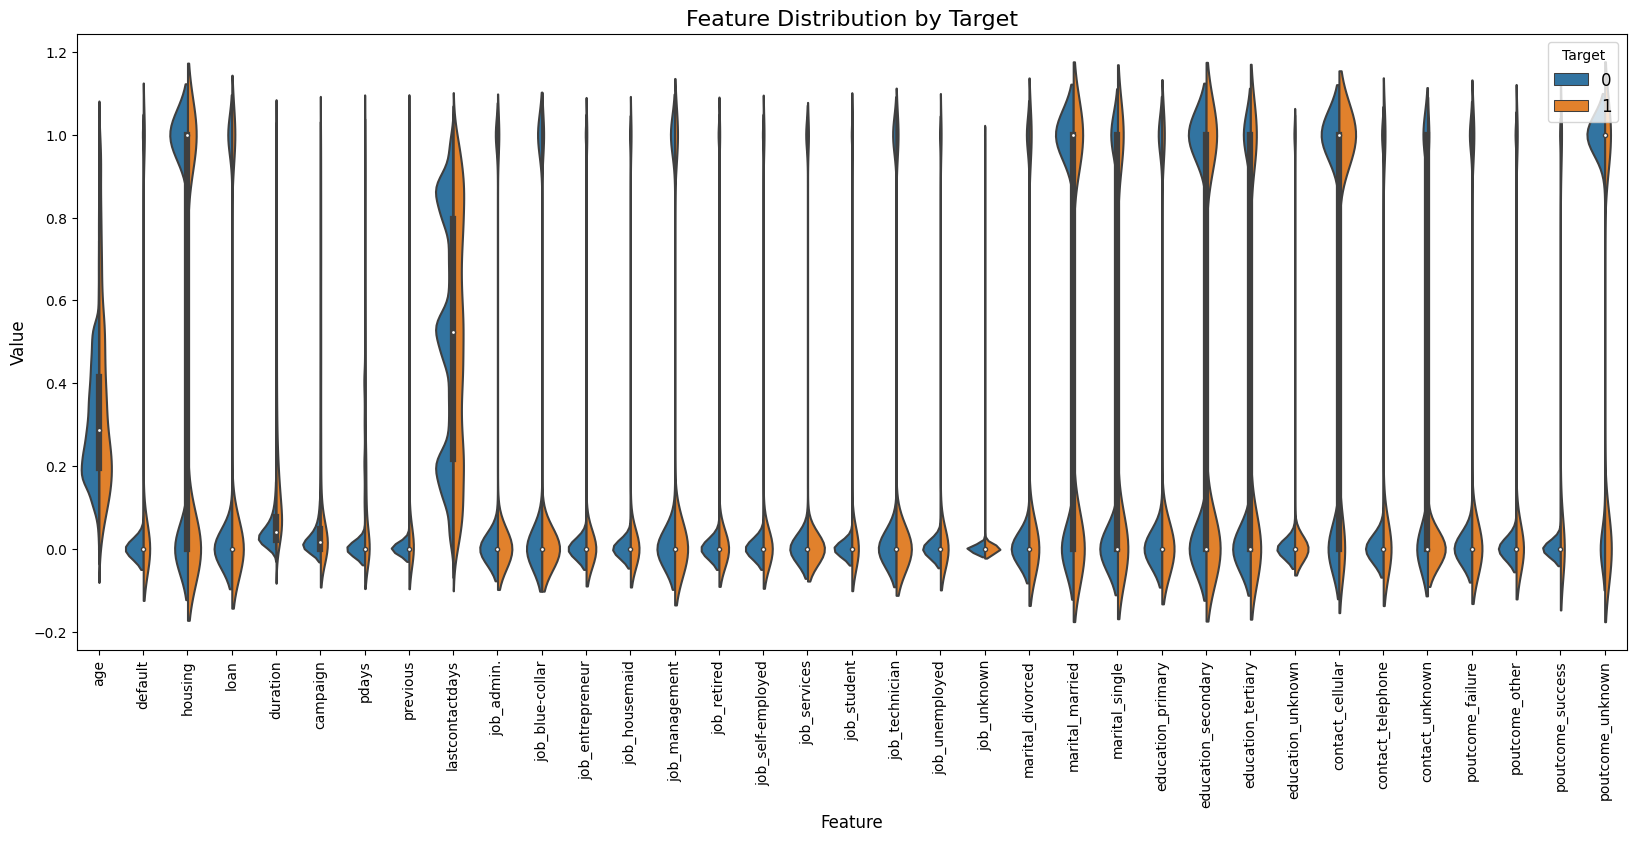

In [17]:
train_ = train.melt(id_vars='target', var_name='Feature', value_name='Value')
train_ = train_[train_['Feature'] != 'balance']
plt.figure(figsize=(20, 8))
sns.violinplot(data=train_, x='Feature', y='Value', hue='target', split=True)
plt.title("Feature Distribution by Target", fontsize=16)
plt.xticks(rotation=90)  
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(title="Target", fontsize=12)
plt.show()

***train-validation split***

In [18]:
x=train.drop('target',axis=1)
y=train['target']
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

***Model-1 Logistic Regression***

In [19]:
model1 = LogisticRegression()
model1.fit(xtrain,ytrain)
ypredict = model1.predict(xtest)
acc=(accuracy_score(ytest, ypredict))
f1=(f1_score(ytest, ypredict))
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8633
F1 Score: 0.3487


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


***Model-2 Random Forest***

In [20]:
model2 = RandomForestClassifier()
model2.fit(xtrain,ytrain)
ypredict = model2.predict(xtest)
acc=(accuracy_score(ytest, ypredict))
f1=(f1_score(ytest, ypredict))
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8703
F1 Score: 0.4887


***Model-3 Light GBM***

In [21]:
model3 = LGBMClassifier()
model3.fit(xtrain,ytrain)
ypredict = model3.predict(xtest)
acc=(accuracy_score(ytest, ypredict))
f1=(f1_score(ytest, ypredict))
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1434
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
Accuracy: 0.8743
F1 Score: 0.5353


***comparison of 3 models***

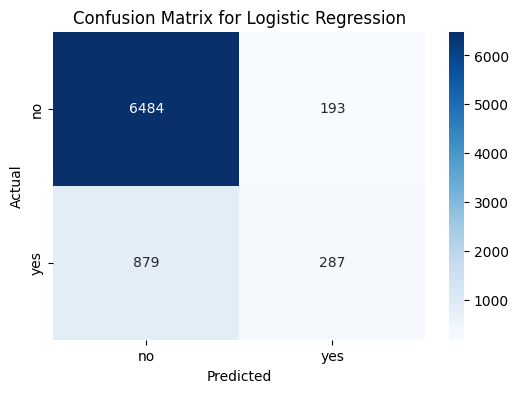

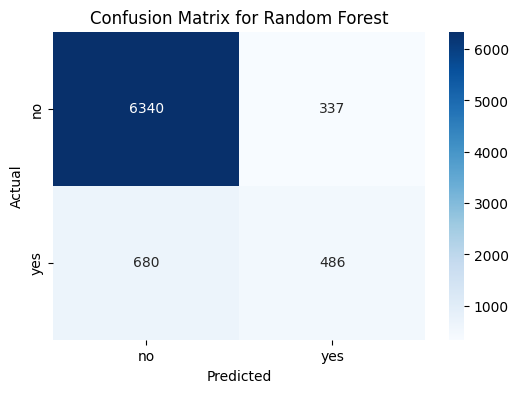

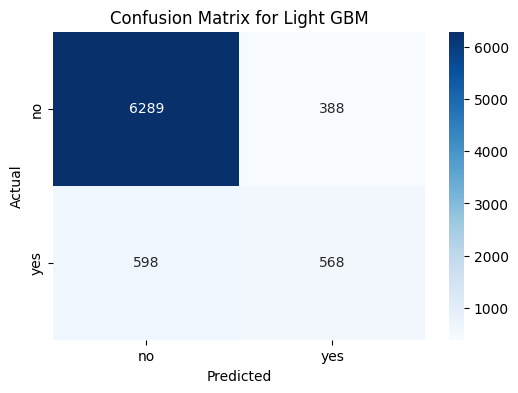

In [22]:
for model_name, model in zip(['Logistic Regression', 'Random Forest', 'Light GBM'], [model1, model2, model3]):
    cm = confusion_matrix(ytest, model.predict(xtest))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True,fmt='d', cmap='Blues',xticklabels=['no','yes'], yticklabels=['no','yes'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

***parameters training***

In [23]:
param = {
    'num_leaves': [50,80,100],
    'max_depth': [8,10],
    'learning_rate': [0.005,0.01],
    'n_estimators': [2000,2500,3000],
    'min_child_samples': [15,18,20],
    'feature_fraction': [0.8],
    'bagging_fraction': [0.8],
    'bagging_freq': [3,5],
    'lambda_l2': [0.1,0.15,0.2],
}
lgbm = LGBMClassifier(boosting_type='gbdt', objective='binary', metric='auc', class_weight='balanced', verbose=-1)
search = RandomizedSearchCV(estimator=lgbm, param_distributions=param,cv=2,scoring='roc_auc',verbose=0,n_iter=10,random_state=42,n_jobs=-1)
search.fit(x, y)
best_model = search.best_estimator_
best_model

LGBMClassifier(bagging_fraction=0.8, bagging_freq=3, class_weight='balanced',
               feature_fraction=0.8, lambda_l2=0.2, learning_rate=0.005,
               max_depth=8, metric='auc', min_child_samples=18,
               n_estimators=3000, num_leaves=50, objective='binary',
               verbose=-1)

In [24]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 80,
    'max_depth': 8,
    'learning_rate': 0.005,
    'n_estimators': 2500,
    'min_child_samples': 18,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'verbose': -1,
    'lambda_l2': 0.15,
    'class_weight': 'balanced'
}

***final model***

In [25]:
model = LGBMClassifier(**params).fit(x,y)
result=model.predict(test)

***Important features from model***

Text(0.5, 1.0, 'Feature Importance')

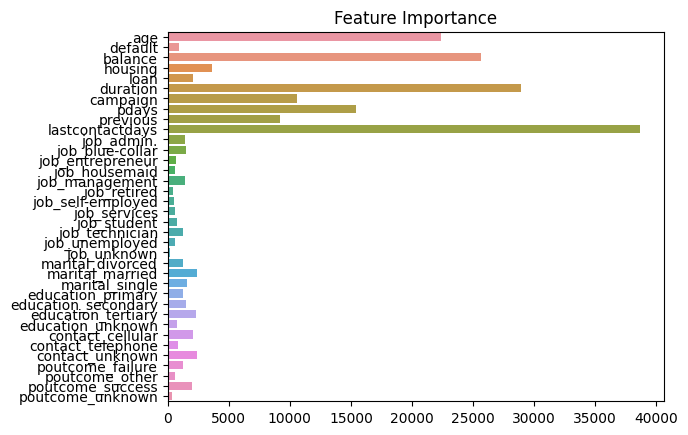

In [26]:
important = model.feature_importances_
sns.barplot(x=important, y=x.columns)
plt.title('Feature Importance')

***submission***

In [27]:
submission=pd.DataFrame({'id':range(0,10000), 'target':result})
submission['target'] = submission['target'].replace({1: 'yes', 0: 'no'})
submission.to_csv('submission.csv',index=False)